LSTM model for Stock price forcasting

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import yfinance as yf
import plotly.graph_objs as go

In [25]:
start_date = '1986-03-19'
end_date = '2024-02-24'

df = yf.download('AAPL', start=start_date, end=end_date)
#df.reset_index(inplace=True)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-19,0.119978,0.121652,0.117746,0.118304,0.091430,189884800
1986-03-20,0.125000,0.132254,0.125000,0.126116,0.097467,904131200
1986-03-21,0.126116,0.128348,0.122768,0.123326,0.095311,260377600
1986-03-24,0.123326,0.123326,0.117746,0.119420,0.092292,294313600
1986-03-25,0.119420,0.124442,0.119420,0.124442,0.096173,281075200


In [26]:
# import pandas as pd

# df = pd.read_csv('AAPL.csv')
# df

In [27]:
df.reset_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-19,0.119978,0.121652,0.117746,0.118304,0.091430,189884800
1,1986-03-20,0.125000,0.132254,0.125000,0.126116,0.097467,904131200
2,1986-03-21,0.126116,0.128348,0.122768,0.123326,0.095311,260377600
3,1986-03-24,0.123326,0.123326,0.117746,0.119420,0.092292,294313600
4,1986-03-25,0.119420,0.124442,0.119420,0.124442,0.096173,281075200


In [28]:
df = df[['Date', 'Close']]

df

,Date,Close
0,1986-03-19,0.118304
1,1986-03-20,0.126116
2,1986-03-21,0.123326
3,1986-03-24,0.119420
4,1986-03-25,0.124442
...,...,...
9555,2024-02-16,182.309998
9556,2024-02-20,181.559998
9557,2024-02-21,182.320007
9558,2024-02-22,184.369995


In [29]:
df['Date']

0      1986-03-19
1      1986-03-20
2      1986-03-21
3      1986-03-24
4      1986-03-25
          ...    
9555   2024-02-16
9556   2024-02-20
9557   2024-02-21
9558   2024-02-22
9559   2024-02-23
Name: Date, Length: 9560, dtype: datetime64[ns]

In [30]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [31]:
# df['Date'] = df['Date'].apply(str_to_datetime)
# df['Date']
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9572\591769443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


0      1986-03-19
1      1986-03-20
2      1986-03-21
3      1986-03-24
4      1986-03-25
          ...    
9555   2024-02-16
9556   2024-02-20
9557   2024-02-21
9558   2024-02-22
9559   2024-02-23
Name: Date, Length: 9560, dtype: datetime64[ns]

In [32]:
df.index = df.pop(df.columns[0])
df.head()

,Close
Date,
1986-03-19,0.118304
1986-03-20,0.126116
1986-03-21,0.123326
1986-03-24,0.119420
1986-03-25,0.124442


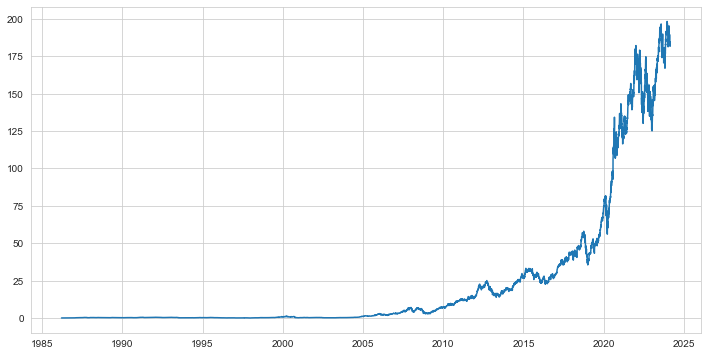

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,6

plt.plot(df.index, df['Close'])

In [34]:
# import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2022-08-10'
windowed_df = df_to_windowed_df(df, 
                                '2022-02-17', 
                                '2024-02-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-02-17,168.880005,172.789993,172.550003,168.880005
1,2022-02-18,172.789993,172.550003,168.880005,167.300003
2,2022-02-22,172.550003,168.880005,167.300003,164.320007
3,2022-02-23,168.880005,167.300003,164.320007,160.070007
4,2022-02-24,167.300003,164.320007,160.070007,162.740005
...,...,...,...,...,...
501,2024-02-16,185.039993,184.149994,183.860001,182.309998
502,2024-02-20,184.149994,183.860001,182.309998,181.559998
503,2024-02-21,183.860001,182.309998,181.559998,182.320007
504,2024-02-22,182.309998,181.559998,182.320007,184.369995


In [35]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((506,), (506, 3, 1), (506,))

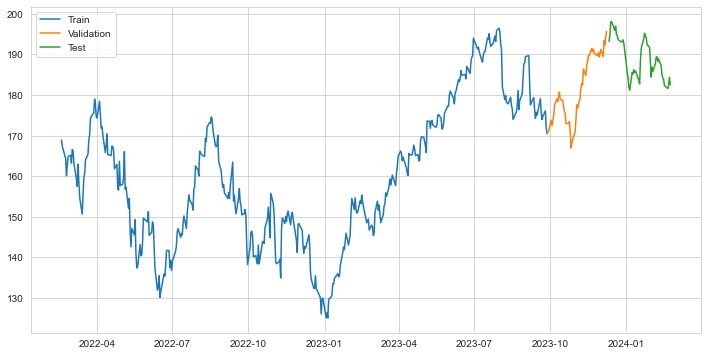

In [36]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
model=Sequential([layers.Input((3,1)),
                 layers.LSTM(64),
                 layers.Dense(32, activation='relu'),
                 layers.Dense(32, activation='relu'),
                 layers.Dense(1)])
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
# model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100)

Epoch 1/100
13/13 [==============================] - 2s 41ms/step - loss: 25827.4785 - mean_absolute_error: 159.8187 - val_loss: 32715.8574 - val_mean_absolute_error: 180.6952
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 25496.7988 - mean_absolute_error: 158.7834 - val_loss: 32371.7031 - val_mean_absolute_error: 179.7403
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 25182.7793 - mean_absolute_error: 157.7910 - val_loss: 31954.7520 - val_mean_absolute_error: 178.5764
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 24648.7969 - mean_absolute_error: 156.0857 - val_loss: 31000.8242 - val_mean_absolute_error: 175.8838
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 23386.2188 - mean_absolute_error: 151.9900 - val_loss: 29062.0938 - val_mean_absolute_error: 170.2840
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 21421.7344 - mean_absolute_error: 145.3417 - val_lo

13/13 [==============================] - 0s 5ms/step - loss: 10.3386 - mean_absolute_error: 2.5354 - val_loss: 6.4599 - val_mean_absolute_error: 2.0973
Epoch 50/100
13/13 [==============================] - 0s 5ms/step - loss: 10.0217 - mean_absolute_error: 2.5068 - val_loss: 6.4235 - val_mean_absolute_error: 2.0915
Epoch 51/100
13/13 [==============================] - 0s 5ms/step - loss: 9.9585 - mean_absolute_error: 2.4736 - val_loss: 6.4101 - val_mean_absolute_error: 2.0977
Epoch 52/100
13/13 [==============================] - 0s 5ms/step - loss: 10.7398 - mean_absolute_error: 2.6066 - val_loss: 6.0425 - val_mean_absolute_error: 2.0168
Epoch 53/100
13/13 [==============================] - 0s 5ms/step - loss: 10.0727 - mean_absolute_error: 2.5001 - val_loss: 6.6717 - val_mean_absolute_error: 2.1441
Epoch 54/100
13/13 [==============================] - 0s 5ms/step - loss: 10.0265 - mean_absolute_error: 2.5292 - val_loss: 5.5835 - val_mean_absolute_error: 1.9510
Epoch 55/100
13/13 [====

Epoch 99/100
13/13 [==============================] - 0s 5ms/step - loss: 9.1596 - mean_absolute_error: 2.3239 - val_loss: 3.4123 - val_mean_absolute_error: 1.4596
Epoch 100/100
13/13 [==============================] - 0s 5ms/step - loss: 9.6161 - mean_absolute_error: 2.4126 - val_loss: 7.9833 - val_mean_absolute_error: 2.4218


In [38]:
model.save('LSTM_model.h5')

C:\Users\ADMIN\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 0s 2ms/step


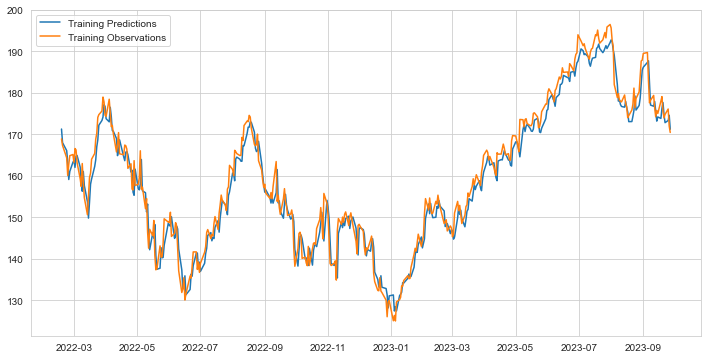

In [39]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 3ms/step


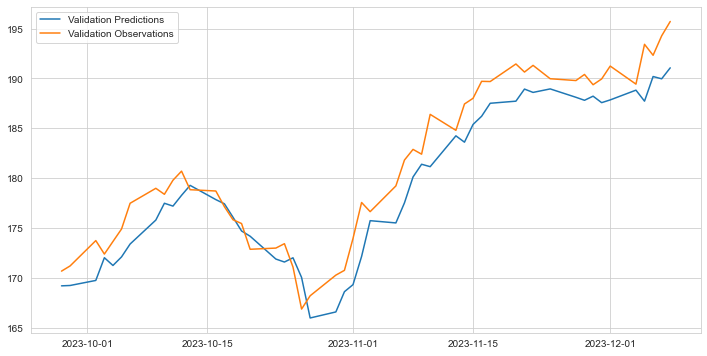

In [40]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 0s/step


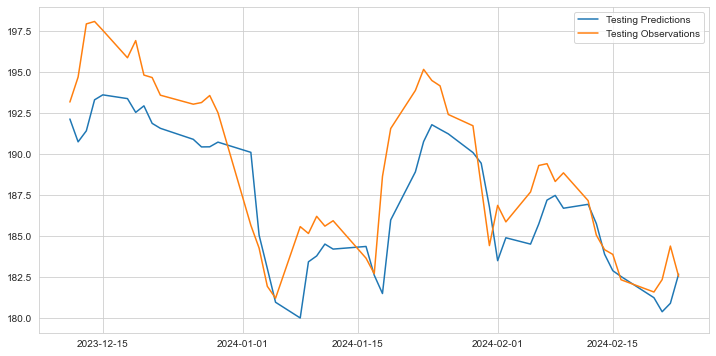

In [41]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
sns.set_style('whitegrid')

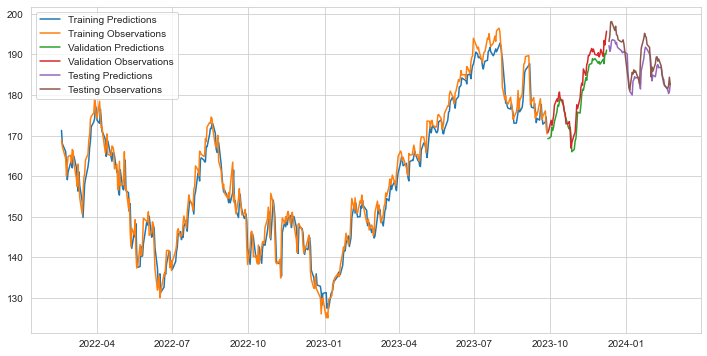

In [42]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])
sns.set_style('whitegrid')

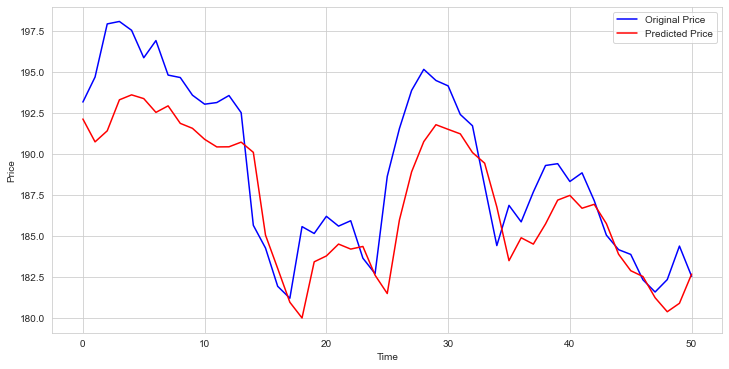

In [43]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b', label ='Original Price')
plt.plot(test_predictions,'r',label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
sns.set_style('whitegrid')

In [44]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 18ms/step


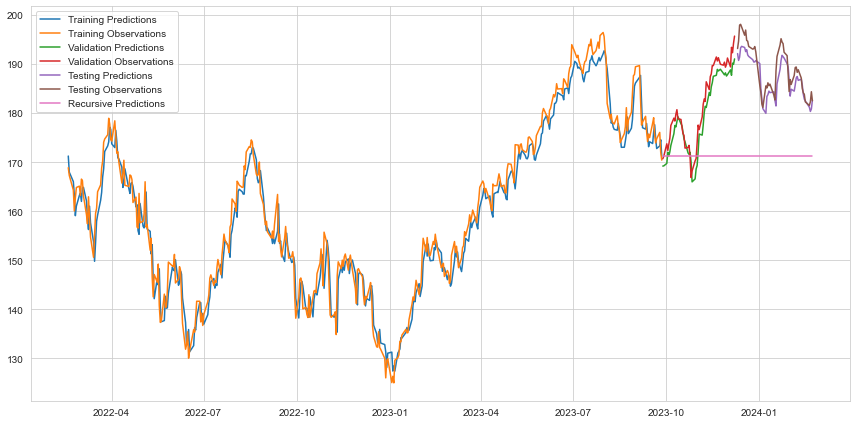

In [45]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,6
sns.set_style('whitegrid')
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 25ms/step


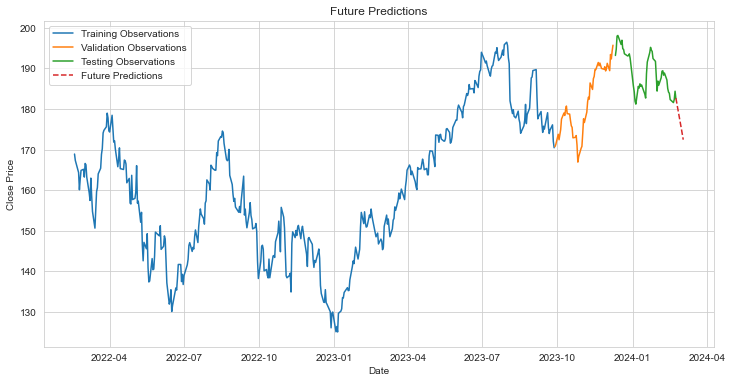

In [46]:
future_dates = pd.date_range(start=dates_test[-1], periods=10, freq='D')

# Reshape the last observed sequence to match the input shape of the model
last_sequence = X_test[-1].reshape((1, X_test.shape[1], 1))

# Generate future predictions
future_predictions = []
for _ in range(10):
    # Predict the next value
    next_prediction = model.predict(last_sequence)
    
    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction[0])
    
    # Update last_sequence by removing the first element and appending the predicted value
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1][-1] = next_prediction

# Convert the predictions to numpy array
future_predictions = np.array(future_predictions).flatten()

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, label='Training Observations')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Future Predictions')
plt.legend()
plt.show()